# Identify parcel runs start locations

In [1]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

#### Parameters

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179
isize = imax - imin
jsize = jmax - jmin

# colors:
land_color = '#a9a7a2'

#### Files

In [3]:
# ANHA12 mesh grid:
mesh         = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mesh['nav_lon'].values
mesh_lat     = mesh['nav_lat'].values
mesh_bathy   = mesh['tmask'][0,:,:,:].values
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
ocean_masked = np.ma.masked_where((mesh_bathy<0.1), mesh_bathy)
depths       = mesh['nav_lev'].values

#### Functions

In [14]:
def save_file(lon, lat, depth, filepath):    
    file_write = xr.Dataset(
        {'longitude' : (("x"), lon),
         'latitude'  : (("y"), lat),
         'depth'     : (("z"), depth)}, 
        coords = {"z": depth,
                  "y": lat,
                  "x": lon},
    )
    file_write.longitude.attrs['units'] = 'degrees East'
    file_write.latitude.attrs['units']  = 'degrees West'
    file_write.depth.attrs['units']     = 'm'

    file_write.to_netcdf(f'{filepath}')
    
    return

In [5]:
def plot_locations(release_lon, release_lat, depth=0, zoom='full'):

    if zoom=='full':
        fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))        
        ax1.plot(x_ANHA12[imin:imax,jmin], y_ANHA12[imin:imax,jmin], '-k', linewidth=1.0)
        ax1.plot(x_ANHA12[imin:imax,jmax], y_ANHA12[imin:imax,jmax], '-k', linewidth=1.0)
        ax1.plot(x_ANHA12[imin,jmin:jmax], y_ANHA12[imin,jmin:jmax], '-k', linewidth=1.0)
        ax1.plot(x_ANHA12[imax,jmin:jmax], y_ANHA12[imax,jmin:jmax], '-k', linewidth=1.0)
    elif zoom=='CAA':
        fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/Pb-CAA-zoom.pickle','rb'))
    else:
        print('Not a zoom option. Choose from full and CAA')
        return

    x_plot, y_plot     = proj1(release_lon, release_lat)
    x_ANHA12, y_ANHA12 = proj1(mesh_lon, mesh_lat)

    proj1.contourf(x_ANHA12, y_ANHA12, bathy_masked[depth,:,:], colors=[land_color], zorder=1) #Apply land mask

    ax1.scatter(x_plot, y_plot, zorder=4, s=3, edgecolor='k', linewidth=0.2)
    
    return

#### Main work

In [11]:
PC_lat   = np.linspace(74.3, 76, 20)
PC_lon   = np.ones(PC_lat.shape)*-123 
PC_depth = np.copy(depths[0:30])

# Release each parcel at a particular lon, lat, and depth:
PC_lats   = np.tile(PC_lat, len(PC_depth))
PC_lons   = np.tile(PC_lon, len(PC_depth))
PC_depths = np.tile(PC_depth, len(PC_depth))

# depths: release for each of the top 29 grid cells (just above the bottom of the main parts of Parry Channel)
# time: released at the start of every month for years 2012-2016

# possible questions: general change over transect, Barrow Sill change

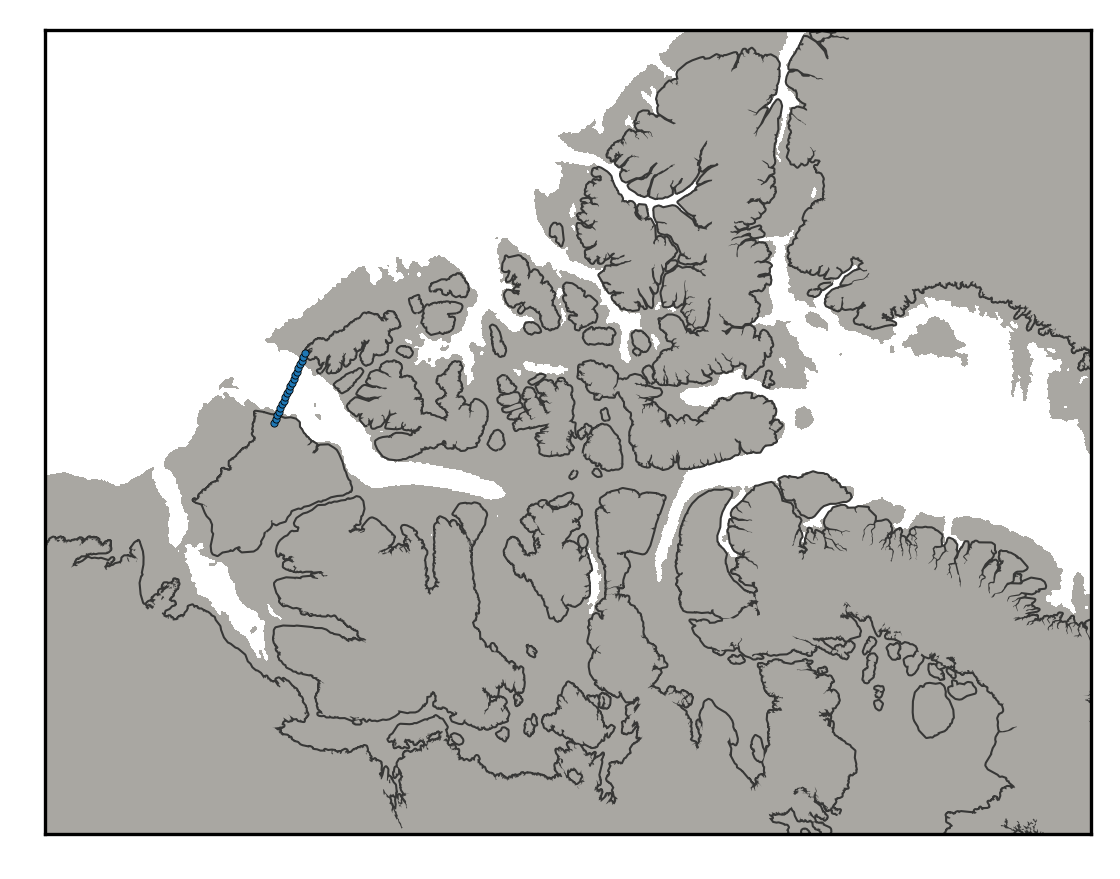

In [12]:
plot_locations(PC_lon, PC_lat, depth=29, zoom='CAA')

#### Save file

In [15]:
# Write release longitudes, latitudes, and depths to file:
save_file(PC_lons, PC_lats, PC_depths, '/ocean/brogalla/GEOTRACES/parcels/Pb-chapter/western-PC-transect-parcels.nc')